In [1]:
import torch
from tqdm.auto import tqdm

from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim*4),
            self.make_gen_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim*2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )
        
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(num_features=output_channels),
                nn.ReLU()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                nn.Tanh()
            )
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        X = self.unsqueeze_noise(noise)
        return self.gen(X)

wrap the convolution layer with spectral norm

In [3]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim*2),
            self.make_disc_block(hidden_dim*2, 1, final_layer=True),
        )
    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride)),
                nn.BatchNorm2d(num_features=output_channels),
                nn.LeakyReLU(negative_slope=0.2),
            )
        else:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride)),
            )
            
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [4]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 1000

batch_size = 128
lr = 0.0002

beta1 = 0.5
beta2 = 0.999

device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

dataloader = DataLoader(
    MNIST('../W1 Intro to GAN/', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True
)


In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [6]:
gen = Generator(z_dim).to(device=device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, beta2))

disc = Discriminator().to(device=device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, beta2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.2)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)


In [7]:

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 0.6419162181913851, discriminator loss: 0.7341727844476698


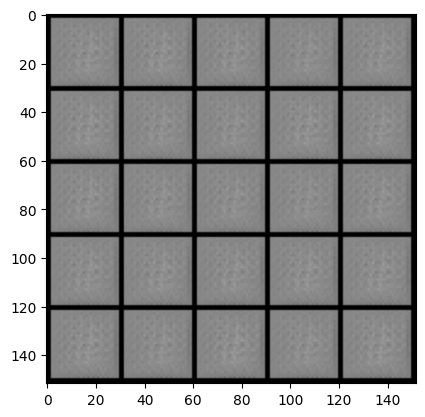

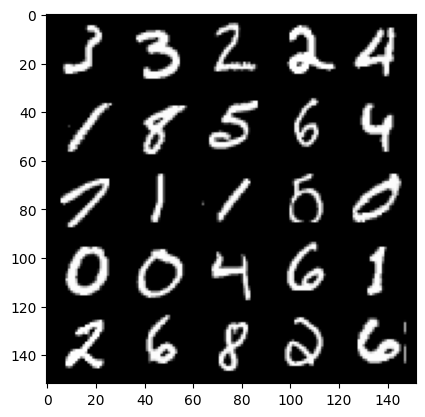

KeyboardInterrupt: 

In [8]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()  # Reset gradients for the discriminator
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)  # Generate random noise
        fake = gen(fake_noise)  # Generate fake data from the generator
        disc_fake_pred = disc(fake.detach())  # Predictions of the discriminator for fake data
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))  # Loss for fake data
        disc_real_pred = disc(real)  # Predictions of the discriminator for real data
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))  # Loss for real data
        disc_loss = (disc_fake_loss + disc_real_loss) / 2  # Combined discriminator loss

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)  # Backpropagate and compute gradients
        # Update optimizer
        disc_opt.step()  # Update discriminator's weights

        ## Update generator ##
        gen_opt.zero_grad()  # Reset gradients for the generator
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)  # Generate more random noise
        fake_2 = gen(fake_noise_2)  # Generate more fake data from the generator
        disc_fake_pred = disc(fake_2)  # Predictions of the discriminator for the new fake data
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))  # Generator loss

        gen_loss.backward()  # Backpropagate and compute generator gradients
        gen_opt.step()  # Update generator's weights

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)  # Display generated images
            show_tensor_images(real)  # Display real images
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
